# Image classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob,string
from tqdm import tqdm
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array
import cv2
import png
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import IncrementalPCA
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

path = '/home/giovanni/git/gioriz.github.io/data/coil-100/*.png'
# path = '/home/giovanni/git/gioriz.github.io/data/coil_red_data/*.png'
#list files
files=glob.glob(path)

Using TensorFlow backend.


## 1. Import and clean data

In [2]:
import codecs
def createDF(files):
    data = []
    for i in files:
        data.append((i, 
        int(i.split('/')[-1][3:i.split('/')[-1].index('__')]),
        int(i.split('/')[-1][i.split('/')[-1].index('__')+2:-4])))
    return pd.DataFrame(data,columns=['path','label','angle'])

In [3]:
# We create a dataframe of path variables, with object and angle
# labels (credits to https://www.kaggle.com/criscastromaya/cnn-
# for-image-classification-in-coil-100-dataset)
df=createDF(files)

In [4]:
# We create a train and a teest set stratifying by lable in order
# to make sure we have a similar incidence of each object in
# train and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    np.array(df.path), np.array(df.label), test_size=0.3,random_state=13,
    stratify = df.label)

In [12]:
# Let's check if TensorFlow is using the GPU as a backend
while tf.test.is_gpu_available()==False:
    print('Do you want to install tensorflow-gpu?')
    x = input()
    if x=='Yes':
        !pip install tensorflow-gpu
        break
    elif x=='No':
        break
    else:
        print('Answer "Yes" or "No"')

Do you want to install tensorflow-gpu?
ninoin
Answer "Yes" or "No"
Do you want to install tensorflow-gpu?
No


In [5]:
# using keras, we parse the image into a list of arrays, namely
# X_train. Each element of this list is an image encoded as an outer
# product of 3 arrays, 2 of which are 128-dimensional coordinate
# arrays and 1 is a 3 dimensional colour array. Each of the 5040
# images in the training set is therefore encoded in 49,152
# array values (3*128**2). 
# X_train[k] is image k (128, 128, 3)
# X_train[k][j] is row j of image k (128, 3)
# X_train[k][j][i] is row j, column i of image k (3,)

def rgb2gray(rgb):
    '''converts an image to Luna coding'''
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


X_train_bw_4096px = np.asarray([cv2.resize(rgb2gray(img_to_array(cv2.imread(
    file).astype("float")/255.0)).reshape(128,128),dsize=(64, 64),\
        interpolation=cv2.INTER_AREA) for file in tqdm(X_train)])

X_test_bw_4096px = np.asarray([cv2.resize(rgb2gray(img_to_array(cv2.imread(
    file).astype("float")/255.0)).reshape(128,128),dsize=(64, 64),\
        interpolation=cv2.INTER_AREA) for file in tqdm(X_test)])

100%|██████████| 2160/2160 [00:31<00:00, 69.48it/s]


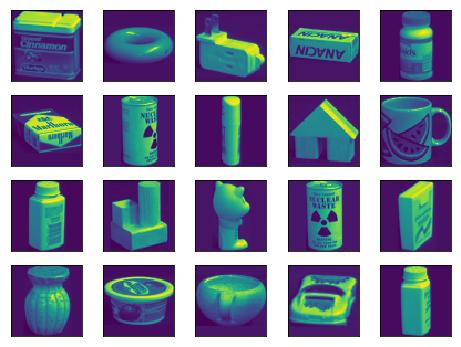

In [105]:
import matplotlib.pyplot as plt
# Let's have a look at these images
fig = plt.figure(figsize=(8, 6))

for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train_bw_4096px[i], cmap='viridis')

In [6]:
# We reshape the 3d array to 2d.
X_train_bw_4096px = X_train_bw_4096px.reshape(
    X_train_bw_4096px.shape[0],
    X_train_bw_4096px.shape[1]*X_train_bw_4096px.shape[2])

X_test_bw_4096px = X_test_bw_4096px.reshape(
    X_test_bw_4096px.shape[0],
    X_test_bw_4096px.shape[1]*X_test_bw_4096px.shape[2])

# We 

X_train_bw_4096px_norm=scale(X_train_bw_4096px)
X_test_bw_4096px_norm=scale(X_test_bw_4096px)

In [81]:
pca = PCA(n_components=2, svd_solver='randomized', whiten=True)
X_train_red = pca.fit_transform(X_train_bw_4096px_norm.data)
X_test_red = pca.fit_transform(X_test_bw_4096px_norm.data)


# At this point my miserable 4Gb of RAM just could not handle the
# 128*128*3*5040 = 247.726.080 dimensions of the dataset.
# I decided to analyse only black and white images and to
# reduce the resolution by a factor of 2*2=4

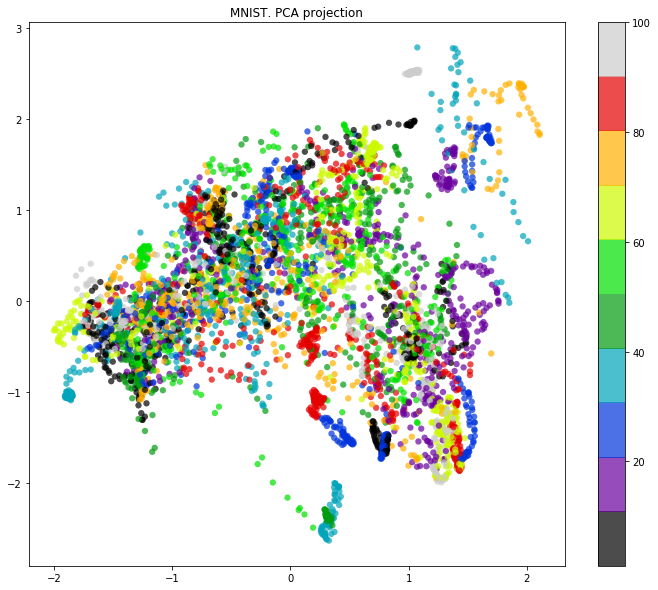

In [111]:
# y_train = y_train.apply(lambda x: int(x[x.index('j')+1:]))
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

In [82]:
%%time
clf = LogisticRegression(C=2, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf.fit(X_train_red, y_train)
y_pred = clf.predict(X_test_red)

print("Accuracy: %f" % accuracy_score(y_test, y_pred))

CPU times: user 4.07 s, sys: 120 ms, total: 4.19 s
Wall time: 2.11 s


Note that an accuracy of 30% is actually very good in this case. Since we have 100 possible categories, picking at random would yield successful results in 1% of cases. Therefore our model represents a 30x improvement on the benchmark case

In [ ]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X_train_bw_4096px_norm)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

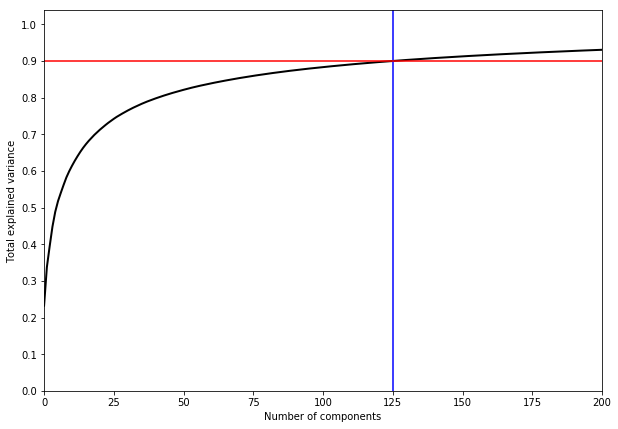

CPU times: user 2min 47s, sys: 13.8 s, total: 3min 1s
Wall time: 3min 26s


In [112]:
%%time
pca = decomposition.PCA(whiten=True).fit(X_train_bw_4096px_norm)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.axvline(125, c='b')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show();

So with 125 components we should be capturing 90% of the variance. Note that copared to the 4096 original components we have substantially reduced complexity

In [82]:
%%time
pca_optimal = PCA(n_components=36, svd_solver='randomized', whiten=True)
try:
    X_red_train_optimal = pca_optimal.fit_transform(X_train_bw_4096px_norm)
    X_red_test_optimal = pca_optimal.fit_transform(X_test_bw_4096px_norm)
except MemoryError:
    print ('Ooops! You should reduce matrix dimensionality')

# At this point my miserable 4Gb of RAM just could not handle the
# 128*128*3*5040 = 247.726.080 dimensions of the dataset.
# I decided to analyse only black and white images and to
# reduce the resolution by a factor of 2*2=4

CPU times: user 6.34 s, sys: 171 ms, total: 6.51 s
Wall time: 3.27 s


In [83]:
%%time
clf = LogisticRegression(C=100, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf.fit(X_red_train_optimal, y_train)
y_pred = clf.predict(X_red_test_optimal)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Accuracy: 0.140278
CPU times: user 44.5 s, sys: 1.33 s, total: 45.9 s
Wall time: 23 s


Looks like something is terribly wrong! Accuracy is down to 6%!
Interestingly with only two components, the accuracy was 0.25
so with 123 extra components we are actually making a worse estimate.
Something is clearly not right.

In [87]:
clf.score(X_red_train_optimal, y_train)

1.0

AHA! Maybe we are overfitting, and PCA with less components works better only because it reduces dimensioanlity, hance providing a cure for overfitting as side-effect. Let's chose the best regularisation parameter.

In [18]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 100)
logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1, max_iter=1000)
logit_searcher.fit(X_red_train_optimal, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.7min finished


CPU times: user 9.25 s, sys: 293 ms, total: 9.55 s
Wall time: 16min 48s


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02, 5.72236766e-02,
       6.42807312e-02, 7.22080902e-02, 8.11130831e-02, 9.11162756e-02,
       1.02353102e-01, 1.14...
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=1000, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

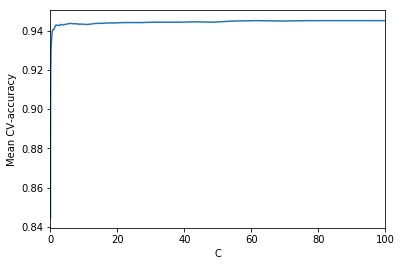

In [53]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((0,100));

In [58]:
%%time
clf_regul = LogisticRegression(C=2, multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)
clf_regul.fit(X_red_train_optimal, y_train);
y_pred = clf_regul.predict(X_red_test_optimal)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

CPU times: user 15.5 s, sys: 325 ms, total: 15.8 s
Wall time: 9.01 s


In [25]:
Cs = np.logspace(-4, 4, 5)
Cs

array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])

Still terrible results! I am puzzled but I decide to fine tune the number of principal components, given that it appears accuracy is not monotonic with respect to the number of principal components. Maybe the issue is connected with the fact our target variable is categorical and can assume 100 values. A neural network would be a better model for this task. Furthermore we can't use conventional Bayesian solution to multiple values dactegorical variable (categories with less data points are shrunk towards mean) since all the categories have equal relative frequency. However, not stratifying yields even worse results

In [17]:
%%time
n_components = list(range(10,50,2))
Cs = np.logspace(-4, 4, 5)

pca = PCA(svd_solver='randomized', whiten=True)
logit = LogisticRegression(multi_class='multinomial', 
                         random_state=17, solver='lbfgs', 
                         max_iter=10000)

pipe = Pipeline(steps=[('pca', pca), ('logistic', logit)])

estimator = GridSearchCV(pipe,
                        dict(pca__n_components=n_components,
                        logistic__C=Cs), scoring='accuracy',
                        verbose=10, n_jobs=3)
estimator.fit(X_train_bw_4096px_norm, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.1min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  5.7min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:  6.8min
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed:  7.9min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  8.5min
[Parallel(

CPU times: user 48.7 s, sys: 1.82 s, total: 50.5 s
Wall time: 1h 36min 48s


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='randomized', tol=0.0,
                                            whiten=True)),
                                       ('logistic',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                            

In [19]:
estimator.best_params_

{'logistic__C': 100.0, 'pca__n_components': 36}

In [94]:
estimator.best_estimator_.fit(X_train_bw_4096px_norm, y_train);
y_pred = estimator.best_estimator_.predict(X_test_bw_4096px_norm)
print("Accuracy: %f" % accuracy_score(y_test, y_pred))

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=36,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('logistic',
                 LogisticRegression(C=100.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=17,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        22
           2       1.00      1.00      1.00        22
           3       0.96      1.00      0.98        22
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        21
           6       0.95      0.91      0.93        22
           7       1.00      1.00      1.00        22
           8       0.86      0.82      0.84        22
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        21
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        21
          15       0.94      0.81      0.87        21
          16       0.91      0.95      0.93        22
          17       1.00      1.00      1.00        22
          18       1.00    

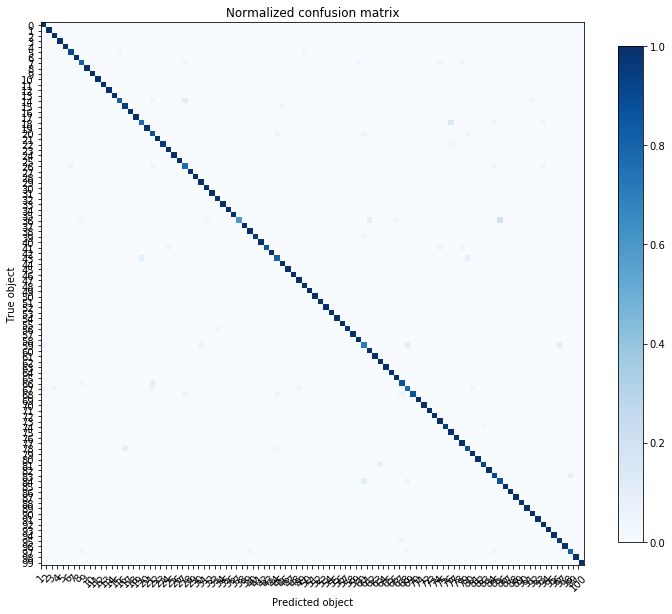

In [44]:
print(classification_report(y_test, y_pred))

M = confusion_matrix(y_test, y_pred)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
im = plt.imshow(M_normalized, interpolation='nearest', cmap='Blues')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(len(set(y_test)))
plt.xticks(tick_marks - 0.5, set(y_test), rotation=45)
plt.yticks(tick_marks)
plt.tight_layout()
plt.ylabel('True object')
plt.xlabel('Predicted object')
plt.title('Normalized confusion matrix')
plt.show()

In [74]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

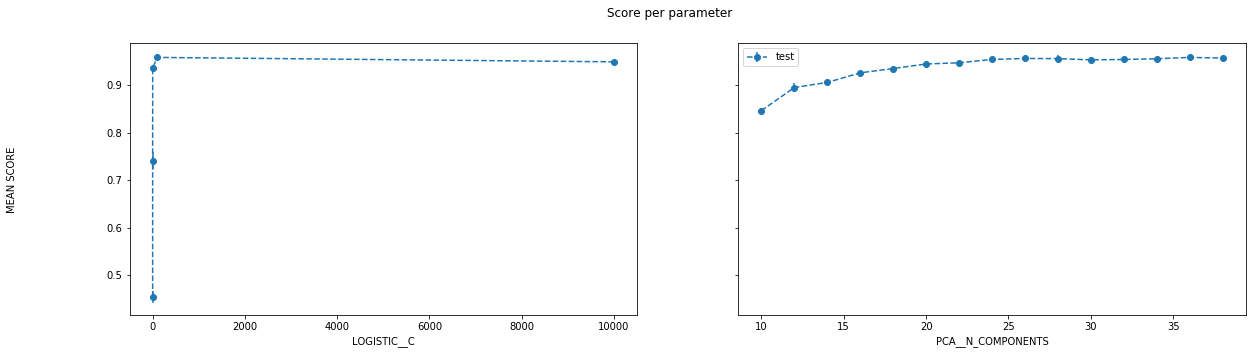

In [75]:
plot_search_results(estimator)